# Calculate relationship between AP and dendritic spikes with poisson excitation

The simulations had either: 
1. Poisson inhibition at the soma and dendrites 
2. Poisson excitation at the soma and dendrites

Here we calculate the spike-triggered average between dendritic spikes and action potentials. These are stratified by:
1. electrotonic distance of the dendritic segment from the soma
2. whether the dendritic branch was apical or basal
3. type of dendritic spike

The output of this script are a collection of NPY files, one for each simulation condition, dendrite type, and dendritic spike type, containing a numpy array with 3 dimensions:
1. the dendritic segment electrotonic quantile
2. time from the action potential

In [1]:
import os
import sys
sys.path.append('..') # have to do this for relative imports in jupyter
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.sta_files import sta_files
from src.load_caspks_csv import load_caspks_csv
from src.load_spike_h5 import load_spike_h5

# Analysis parameters


In [2]:
samps_per_ms = 10 
sim_win = [0, 2000000] # beginning and start points of simulation in samples
sta_win = [-100, 100] # multiply by step to get window in milliseconds
sta_step = 1 # binning step for each point in the STA
step = 2 * samps_per_ms # number of simulation steps for creating the dendritic 
                        # event occurrence series

#### List files to be processed

In [3]:
# locate simulation files
root_dir = 'Z:\\DendOscSub\\output_allpoisson\\'
sim_dict = {'SimName': 'output_allpoisson',
            'RootDir': root_dir,
            'CaFile': root_dir + 'output_allpoisson_ca_nex.csv',
            'NaFile': root_dir + 'output_allpoisson_na_nex.csv',
            'NMDAFile': root_dir + 'output_allpoisson_nmda_nex.csv',
            'APFile': root_dir + 'spikes.h5'}

sim_dict


{'SimName': 'output_allpoisson',
 'RootDir': 'Z:\\DendOscSub\\output_allpoisson\\',
 'CaFile': 'Z:\\DendOscSub\\output_allpoisson\\output_allpoisson_ca_nex.csv',
 'NaFile': 'Z:\\DendOscSub\\output_allpoisson\\output_allpoisson_na_nex.csv',
 'NMDAFile': 'Z:\\DendOscSub\\output_allpoisson\\output_allpoisson_nmda_nex.csv',
 'APFile': 'Z:\\DendOscSub\\output_allpoisson\\spikes.h5'}

#### Generate STAs for dendritic spikes

In [4]:
# process the simulation
pois_sta = {}
pois_sta['ca_sta'] = sta_files(sim_dict['CaFile'], sim_dict['APFile'], 
                               step, sim_win,sta_step,sta_win, agg_colname='Elec_distanceQ')
pois_sta['nmda_sta'] = sta_files(sim_dict['NMDAFile'], sim_dict['APFile'], 
                                 step, sim_win,sta_step,sta_win, agg_colname='Elec_distanceQ')
pois_sta['na_sta'] = sta_files(sim_dict['NaFile'], sim_dict['APFile'], 
                               step, sim_win,sta_step,sta_win, agg_colname='Elec_distanceQ')

pois_sta['ca_a'] = pois_sta['ca_sta'].loc['apic','sta']
pois_sta['nmda_a'] = pois_sta['nmda_sta'].loc['apic','sta']
pois_sta['nmda_b'] = pois_sta['nmda_sta'].loc['dend','sta']
pois_sta['na_a'] = pois_sta['na_sta'].loc['apic','sta']
pois_sta['na_b'] = pois_sta['na_sta'].loc['dend','sta']


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [51]:
eqt_inds

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [52]:
eqt_list

array([9, 8, 7, 6, 5, 4, 3, 2, 1])

In [53]:
pois_sta['nmda_a'].shape

(10, 200)

#### Plot percent change in dendritic event occurrence with repect to APs

In [59]:
t_list = np.arange(sta_win[0], sta_win[1], sta_step) * (step / samps_per_ms)
eqt_list = np.arange(9,-1,-1)

t_inds = np.where(np.abs(t_list)<=50)[0]
eqt_inds = np.arange(0,10)#np.where(eqt_list>0)[0]

def plot_sta_im(data_arr,ax,**kwargs):

    ax_im = ax.imshow(data_arr[eqt_inds[0]:eqt_inds[-2],t_inds[0]:t_inds[-1]], 
                      extent=[t_list[t_inds[0]], t_list[t_inds[-1]],
                              eqt_list[eqt_inds[0]], eqt_list[eqt_inds[-2]]],
                      interpolation='none',
                      cmap='coolwarm',
                      norm=colors.CenteredNorm(vcenter=0), 
                      **kwargs)
    
    plt.colorbar(ax_im,ax=ax)
    ax.axvline(0,color='white',linestyle=':')
    ax.set_aspect('auto')

def plot_sta_stair(data_arr,ax):
    mean_data = np.mean(data_arr[eqt_inds[0]:eqt_inds[-1],t_inds[0]:t_inds[-1]],0)

    ax_im = ax.stairs(mean_data, np.hstack((t_list[t_inds[:-1]], t_list[t_inds[-1]])),
                     fill=True, baseline=0)
    
    ax.axvline(0,color='black',linestyle=':')
    ax.set_aspect('auto')

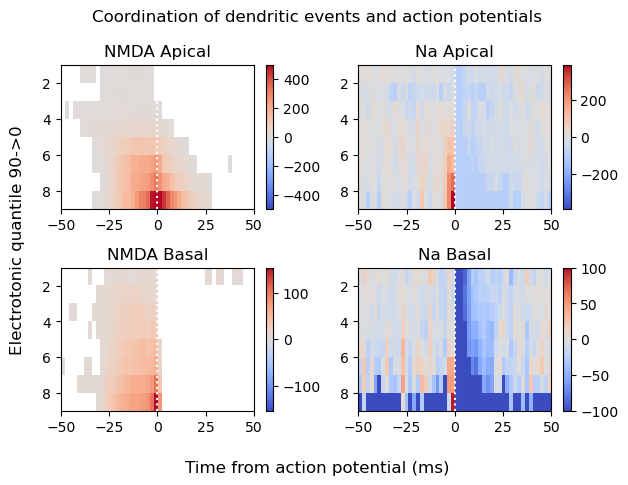

In [60]:
fig,ax = plt.subplots(2,2)
plot_sta_im(pois_sta['nmda_a'], ax[0,0])
ax[0,0].set_title('NMDA Apical')
plot_sta_im(pois_sta['nmda_b'], ax[1,0])
ax[1,0].set_title('NMDA Basal')
plot_sta_im(pois_sta['na_a'], ax[0,1])
ax[0,1].set_title('Na Apical')
plot_sta_im(pois_sta['na_b'], ax[1,1])
ax[1,1].set_title('Na Basal')
fig.supxlabel('Time from action potential (ms)')
fig.supylabel('Electrotonic quantile 90->0')
fig.suptitle('Coordination of dendritic events and action potentials')
fig.tight_layout()
fig.savefig('../figures/DendSpikesCC.pdf')


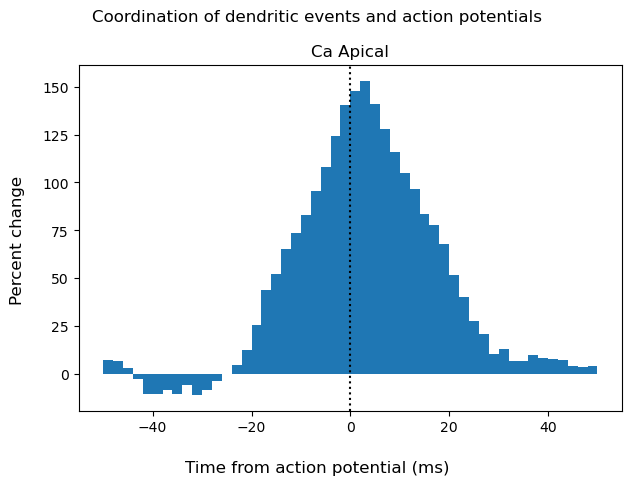

In [7]:
fig,ax = plt.subplots()
plot_sta_stair(pois_sta['ca_a'],ax)
ax.set_title('Ca Apical')
fig.supxlabel('Time from action potential (ms)')
fig.supylabel('Percent change')
fig.suptitle('Coordination of dendritic events and action potentials')
fig.tight_layout()
fig.savefig('../figures/CaSpikesCC.pdf')

#### Plot percent change in dendritic event occurrence with respect to Ca2+ spikes

In [8]:
# process the simulation
pois_ca_sta = {}
pois_ca_sta['nmda_sta'] = sta_files(sim_dict['NMDAFile'], sim_dict['CaFile'], 
                                 step, sim_win,sta_step,sta_win, 
                                 agg_colname='Elec_distance_nexusQ', ca_spk=True)
pois_ca_sta['na_sta'] = sta_files(sim_dict['NaFile'], sim_dict['CaFile'], 
                               step, sim_win,sta_step,sta_win, 
                               agg_colname='Elec_distance_nexusQ', ca_spk=True)

pois_ca_sta['nmda_a'] = pois_ca_sta['nmda_sta'].loc['apic','sta']
pois_ca_sta['na_a'] = pois_ca_sta['na_sta'].loc['apic','sta']


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_caspks_csv.py:30: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  caspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_caspks_csv.py:30: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  caspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precisio

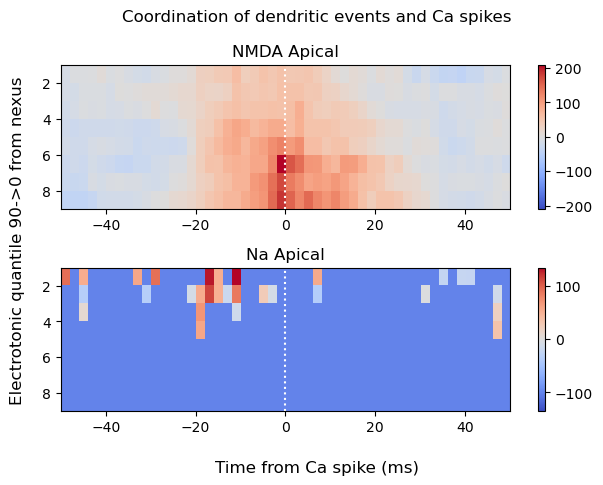

In [62]:
fig,ax = plt.subplots(2,1)
plot_sta_im(pois_ca_sta['nmda_a'], ax[0])
ax[0].set_title('NMDA Apical')
plot_sta_im(pois_ca_sta['na_a'], ax[1])
ax[1].set_title('Na Apical')

fig.supxlabel('Time from Ca spike (ms)')
fig.supylabel('Electrotonic quantile 90->0 from nexus')
fig.suptitle('Coordination of dendritic events and Ca spikes')
fig.tight_layout()
fig.savefig('../figures/DendSpikesCaCC.pdf')

#### Plot how Ca2+ spikes change the coordination between NMDA spikes and APs

c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_caspks_csv.py:30: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  caspk_df = pd.read_csv(fpath)


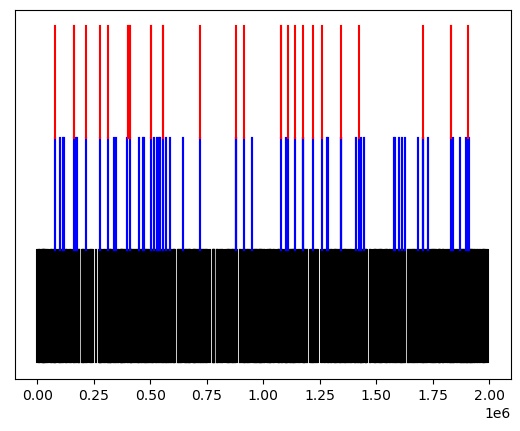

In [10]:
# get spkikes that are 20 ms after the start of a Ca spike
caspk_t = load_caspks_csv(sim_dict['CaFile'])
spk_t = load_spike_h5(sim_dict['APFile'])

lag_win = samps_per_ms * 20
spk_ca_t = [curr_spk for curr_spk in spk_t if np.any(((curr_spk-caspk_t)<lag_win)&((curr_spk-caspk_t)>=0))]


# create a method that makes a raster plot of spike times
def plot_raster(spk_t, ax, offset=0, **kwargs):
    for curr_spk in spk_t:
        ax.plot([curr_spk, curr_spk], np.array([0,1])+offset, **kwargs)
        
    ax.set_yticks([])

# plot the raster
fig,ax = plt.subplots()
plot_raster(spk_t, ax, 0, color='black')
plot_raster(caspk_t, ax, 1, color='blue')
plot_raster(spk_ca_t, ax, 2, color='red')

In [15]:
# process the simulation
pois_canmda_sta = {}
pois_canmda_sta['nmda_sta'] = sta_files(sim_dict['NMDAFile'], spk_ca_t, 
                                 step, sim_win,sta_step,sta_win, 
                                 agg_colname='Elec_distanceQ')
pois_canmda_sta['na_sta'] = sta_files(sim_dict['NaFile'], spk_ca_t, 
                                 step, sim_win,sta_step,sta_win, 
                                 agg_colname='Elec_distanceQ')

pois_canmda_sta['nmda_a'] = pois_canmda_sta['nmda_sta'].loc['apic','sta']
pois_canmda_sta['nmda_b'] = pois_canmda_sta['nmda_sta'].loc['dend','sta']
pois_canmda_sta['na_a'] = pois_canmda_sta['na_sta'].loc['apic','sta']
pois_canmda_sta['na_b'] = pois_canmda_sta['na_sta'].loc['dend','sta']


c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
c:\Users\dbh60\Documents\Analysis\InhibOnDendComp\scripts\..\src\load_dendevt_csv.py:32: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dspk_df = pd.read_csv(fpath)
c:\Users\dbh60\.conda\envs\dend_comp\lib\site-packages\scipy\stats\_axis_nan_policy.py:527: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Resul

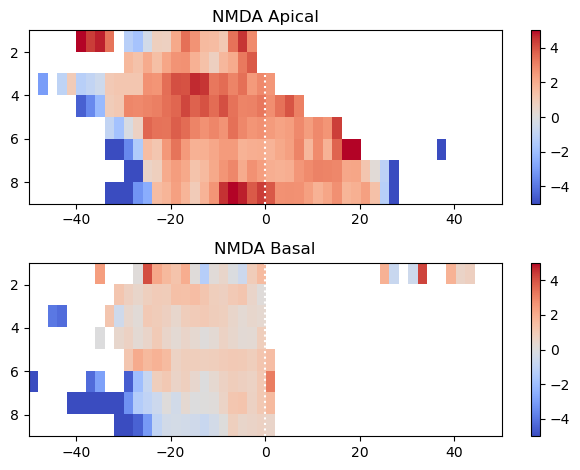

In [63]:
# numpy restrict values to set range
def prc_chg(numer,denom):
    # set denom values less than 10 to nan
    denom[abs(denom<5)] = np.nan
    
    return np.clip(numer/denom,-5,5)

fig,ax = plt.subplots(2,1)
plot_sta_im(prc_chg(pois_canmda_sta['nmda_a'],pois_sta['nmda_a']), ax[0])
ax[0].set_title('NMDA Apical')
plot_sta_im(prc_chg(pois_canmda_sta['nmda_b'],pois_sta['nmda_b']), ax[1])
ax[1].set_title('NMDA Basal')
fig.supxlabel('Time from action potential (ms)')
fig.supylabel('Electrotonic quantile 90->0 from nexus')
fig.suptitle('Fold change in NMDA/AP coordination during Ca spikes')
fig.tight_layout()
